In [38]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
#2.1.0버전에서 1.x 버전의 라이브러리를 실행 가능하게 해줌.
tf.disable_v2_behavior()
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#mnist에서 숫자 손글씨 데이터를 받아옴.

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
#label, 즉 정답을 one_hot encoding으로 변환. 0부터 9까지 {0,0,0,0,0,0,0,0,0,0}으로 변환

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_train Shape:  (60000, 28, 28)
y_train Shape:  (60000, 10)
x_test Shape:  (10000, 28, 28)
y_test Shape:  (10000, 10)


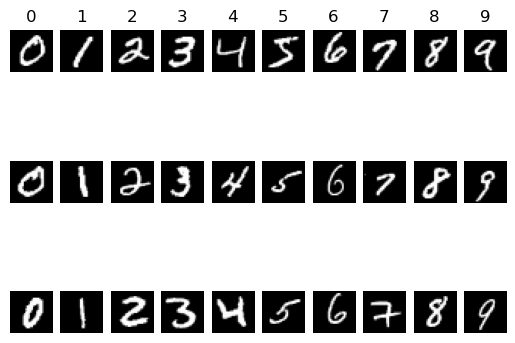

In [40]:
x_train, y_train=train_images, train_labels
x_test, y_test=test_images, test_labels
#그냥 명칭 변경

print("x_train Shape: ", x_train.shape) #28픽셀*28픽셀 이미지. 입력값 x에 해당.
print("y_train Shape: ", y_train.shape) #one_hot encoding으로 10개짜리 배열이 됨.
print("x_test Shape: ", x_test.shape)
print("y_test Shape: ", y_test.shape)
#행렬의 차원 표시. 60000개의 데이터. 최종적으로 60000*28*28 식으로 나옴.

def plot_image(data, classes, width=28, height=28, row_len=3):
    #이미지 출력 함수
    #data는 이미지. classes는 정답. width, height은 28*28픽셀. row_len은 각 숫자 당 보여주는 샘플 수를 의미함.
    for i in range(10):
        #숫자가 0~9까지 10개이므로 10번 반복함. 가로로 나옴.
        idxs = (classes==i)
        #i번 이미지가 맞는지 확인함. 60000개짜리 boolean 배열 생성
        class_images = data[idxs][0:10]
        #그 이미지들 중 10개만 뽑아서 사용함. Mask라는 걸 쓴다 함. 솔직히 여긴 정확히 이해 못했음.
        for j in range(row_len):
            #각 숫자 당 보여주는 샘플 수만큼 반복. 현재는 3개. 세로로 나옴.
            plt.subplot(row_len, 10, i + j*10 +1)
            #격자를 나누어 줌. 이거 안쓰면 맨 끝거 하나만 표시됨. 3*10개의 이미지 출력을 가능하게 함. i+j*10+1번째 칸에 출력한다는 뜻.
            plt.imshow(class_images[j].reshape(width, height), cmap='gray')
            #핵심 줄. 이미지를 화면에 표시. class_images[j]라는 이미지를 표시. cmap='gray'는 흑백이란 뜻.
            if j==0:
                plt.title(i)
                #0 1 2 3 4 5 6 7 8 9 제목 붙여줌.
            plt.axis('off')
            #눈금 없앰. 이거 on 하면 어지러워짐.
    plt.show()

classes=np.argmax(y_train, axis=1)
#one_hot_encoding 되돌림. 가장 큰 수, 즉 1의 인덱스를 리턴하는 함수. 1*60000의 int 배열 리턴됨.
plot_image(x_train, classes)
        

In [42]:
class Autoencoder(object):
    #AutoEncoding 연산을 실제로 진행하는 핵심 함수. 단, 학습 과정을 정의하는 역할만 함.
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.weights = {
            'W_fc1': tf.Variable(tf.random.truncated_normal([self.input_size,
                self.hidden_size], stddev=0.1), name='W_fc1'),#
            'W_fc2': tf.Variable(tf.random.truncated_normal([self.hidden_size,
                self.input_size], stddev=0.1), name='W_fc2'),#
        }
        #weight 초기화. random.truncated_normal()은 정규분포 난수를 뽑고 너무 벗어난 값은 잘라낸단 뜻. 표준편차인 stddev는 0.1로 설정됨.
        #tf.Variable()은 학습대상에 들어가는 변수를 선언한다는 뜻. 사이즈는 함수 선언 시 넣는 파라미터에 의해 결정됨.
        
        self.biases = {
            'b_fc1': tf.Variable(tf.constant(0.1,
                shape = [self.hidden_size]), name='b_fc1'),
            'b_fc2': tf.Variable (tf.constant(0.1,
                shape=[self.input_size]), name='b_fc2'),
        }
        #bias 0.1로 초기화. tf.constant은 예를 들어 (0.1, 100)이면 0.1이 100개 있는 배열 생성하는 식으로 작동.
        
        #참고: GPT 피셜 하필 0.1 고정값인 이유는 weight는 각 뉴런이 다르게 반응해야 해서 랜덤값으로 해야 하지만 bias는 출력을 미세하게 밀어주는 역할이라 필요없음. 그리고 0.1로 한거는 RELU의 출력이 죽는 현상 방지를 위함.
        #참고: AutoEncoder에서는 output_size와 input_size가 같기에 output_size가 없음.
        
        print("self.weights keys:", self.weights.keys())
        #그냥 ['W_fc1', 'W_fc2']라고 출력. 디버깅용 코드.
        self.x_input = tf.compat.v1.placeholder(tf.float32, [None, self.input_size])
        #V1.X용. input을 나중에 넣을 Placeholder라는 빈 변수, 즉 자리 예약 선언. V.2.1.0에선 placeholder가 없음.
        self.hidden = tf.matmul(self.x_input, self.weights['W_fc1']) + self.biases['b_fc1']
        #핵심 연산! hidden 층을 계산하는 forwarding 과정. 행렬곱으로 입력값과 가중치를 곱하고 bias를 더함.
        self.hidden = tf.nn.relu(self.hidden)
        #핵심연산. 복원단계. 아까 한 행렬곱에 relu 활성화 함수를 적용함.
        self.reconstruction = tf.matmul(self.hidden, self.weights['W_fc2'])+self.biases['b_fc2']
        #핵심연산! forwarding. 행렬곱으로 히든에 가중치를 곱하고 bias를 더해서 출력을 만듬. 다만 활성화함수가 없음.
        #cost
        self.loss = tf.losses.mean_squared_error(self.reconstruction, self.x_input)
        #오류 계산. MSE 사용.
        learning_rate = 1e-4
        #학습률 설정. 0.0001로 설정됨.
        optimizer = tf.train.AdamOptimizer(learning_rate)
        #Adam 최적화 알고리즘의 객체를 생성함.
        self.optimizer = optimizer.minimize(self.loss)
        #최적화 과정을 정의함. loss를 최소화.


In [44]:
#hyperparameter
input_size = 28*28
hidden_size = 10*10
#10*10까지 압축시킴.
num_of_iter = 5000
#5000번 학습시킴.
batch_size = 1000
#뱃치. 즉 한번에 학습하는 샘플의 수

In [46]:
sess = tf.compat.v1.InteractiveSession()
#안봐도 무방. 세션을 만듬. 텐서플로 1.X 때에 사용되던 거라 함. 
ae=Autoencoder(input_size, hidden_size)
#핵심코드. 오토인코더 실행. 여기서는 모델의 구조만 정의되고 학습은 아직 안돌아감.
init = tf.global_variables_initializer()
#모든 변수들을 초기화하라는 연산만 만든 상태.
sess.run(init)
#이를 실행해서 모든 Variable을 초기화.

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.
self.weights keys: dict_keys(['W_fc1', 'W_fc2'])


step: 0, loss: 24728.8
Original Image (step: 0)


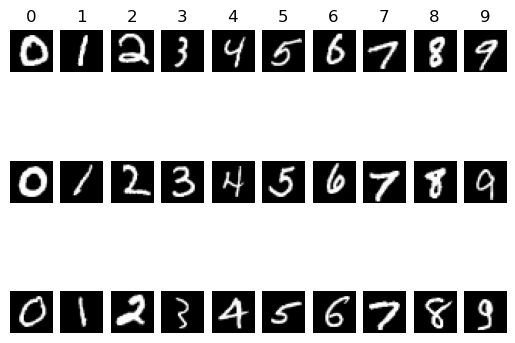


Reconstruction Image (step: 0)


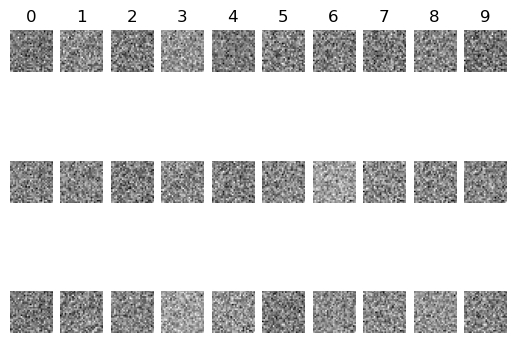

step: 100, loss: 9240.26
Original Image (step: 100)


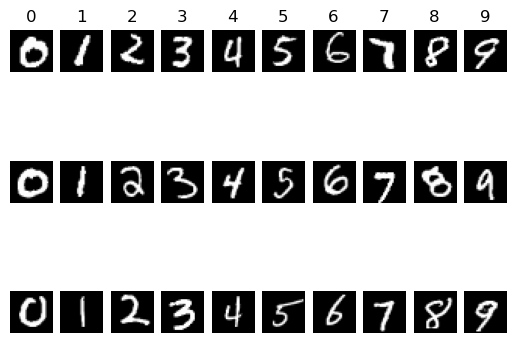


Reconstruction Image (step: 100)


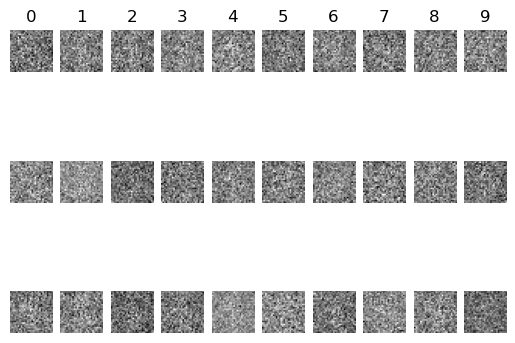

step: 200, loss: 7548.3
Original Image (step: 200)


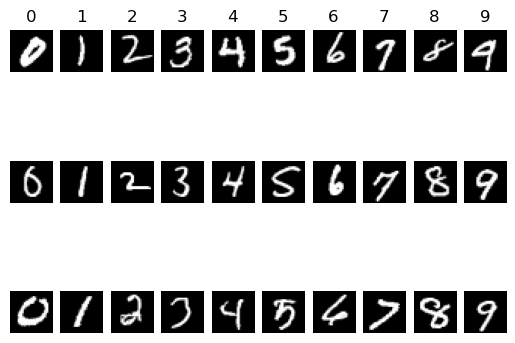


Reconstruction Image (step: 200)


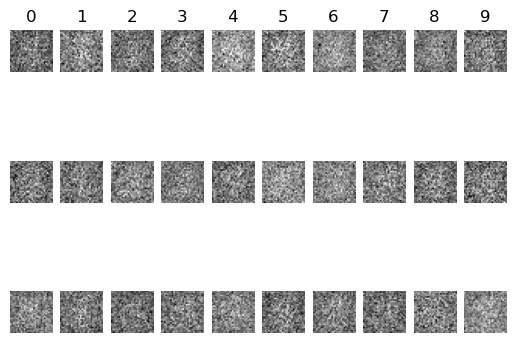

step: 300, loss: 6357.71
Original Image (step: 300)


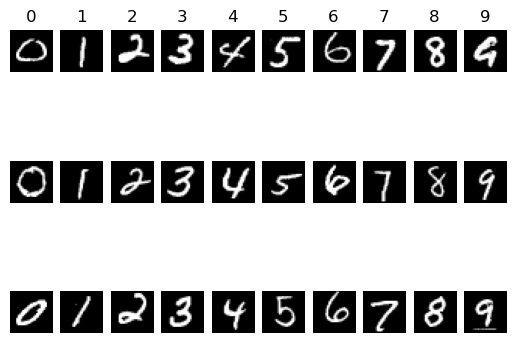


Reconstruction Image (step: 300)


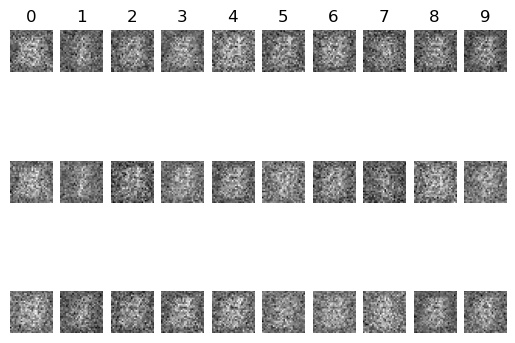

step: 400, loss: 5294.96
Original Image (step: 400)


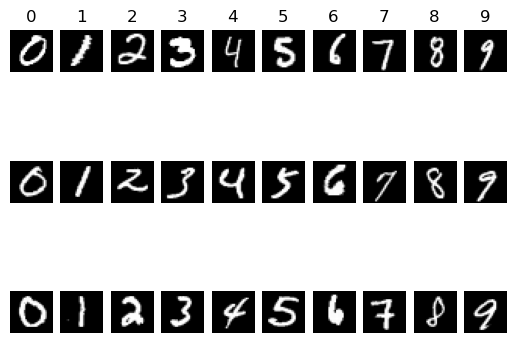


Reconstruction Image (step: 400)


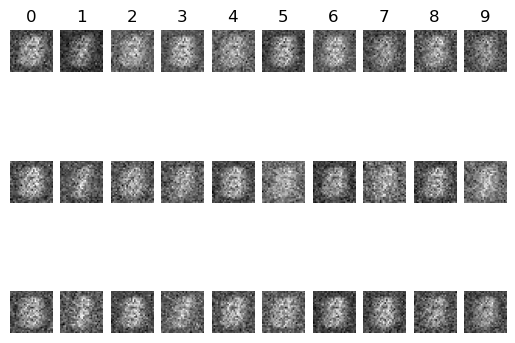

step: 500, loss: 4598.74
Original Image (step: 500)


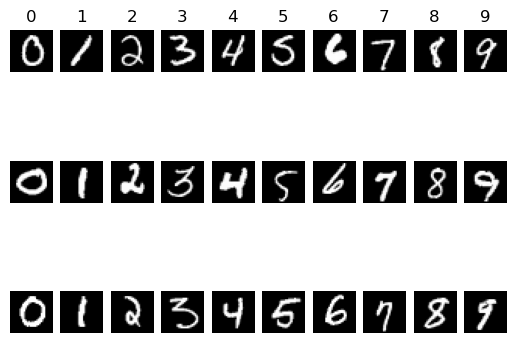


Reconstruction Image (step: 500)


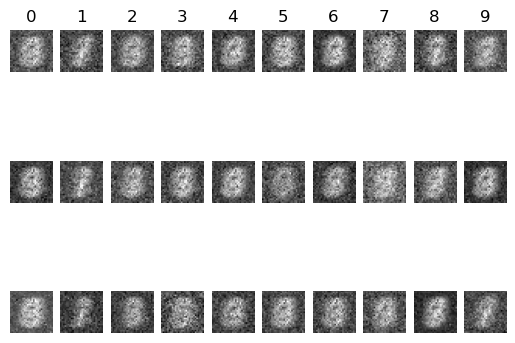

step: 600, loss: 4296.36
Original Image (step: 600)


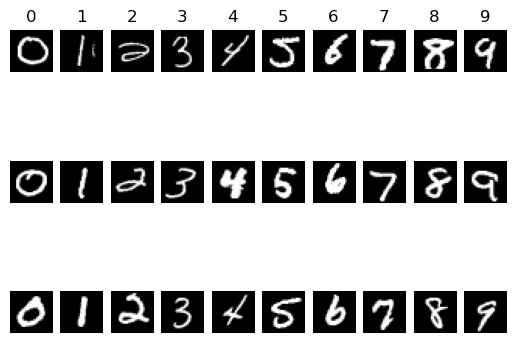


Reconstruction Image (step: 600)


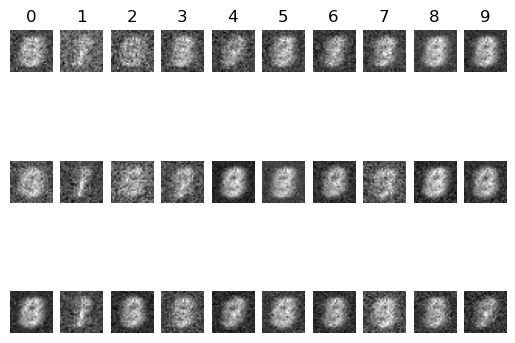

step: 700, loss: 4111.31
Original Image (step: 700)


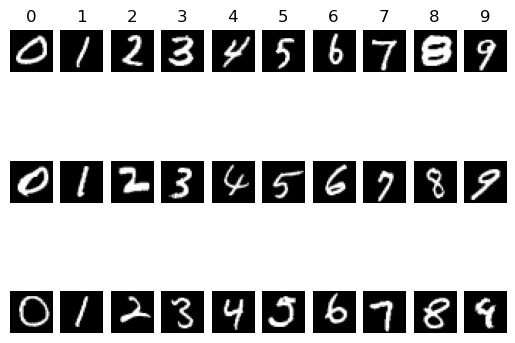


Reconstruction Image (step: 700)


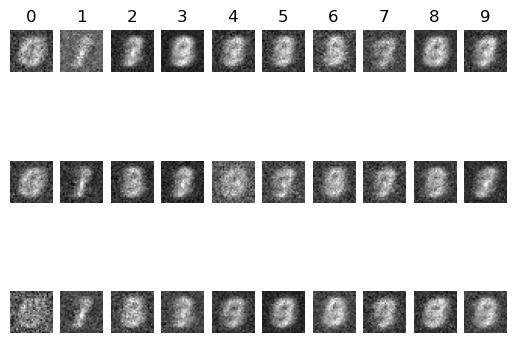

step: 800, loss: 3805.33
Original Image (step: 800)


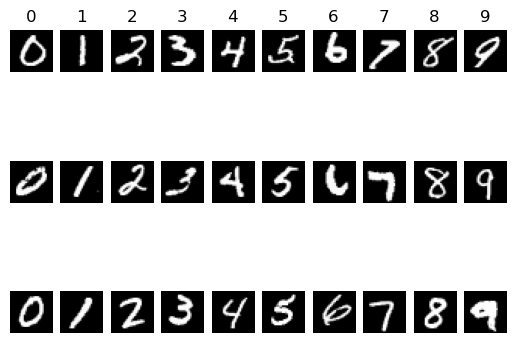


Reconstruction Image (step: 800)


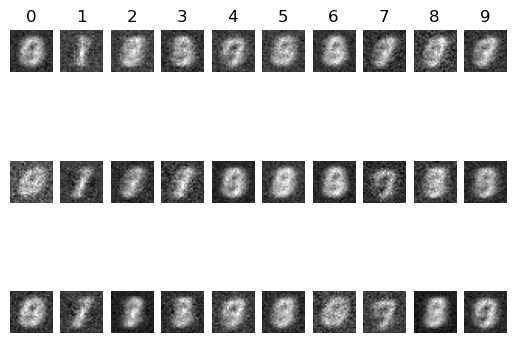

step: 900, loss: 3690.41
Original Image (step: 900)


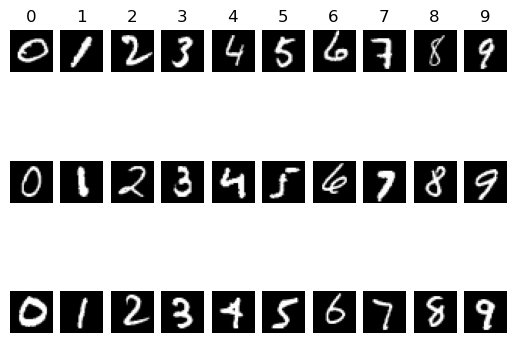


Reconstruction Image (step: 900)


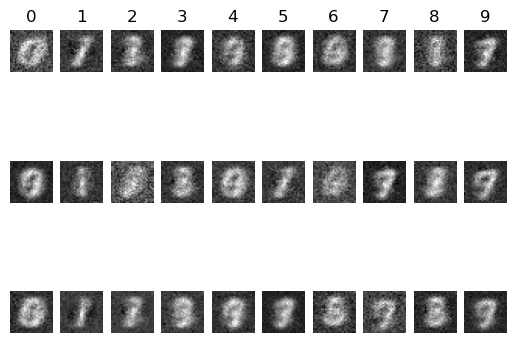

step: 1000, loss: 3501.81
Original Image (step: 1000)


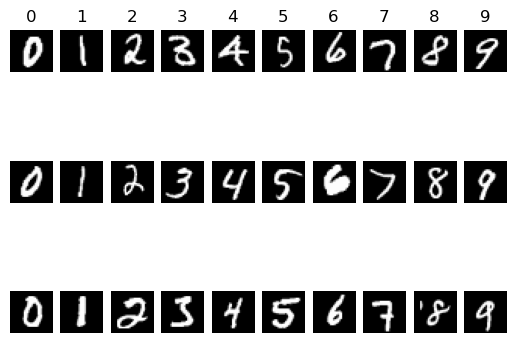


Reconstruction Image (step: 1000)


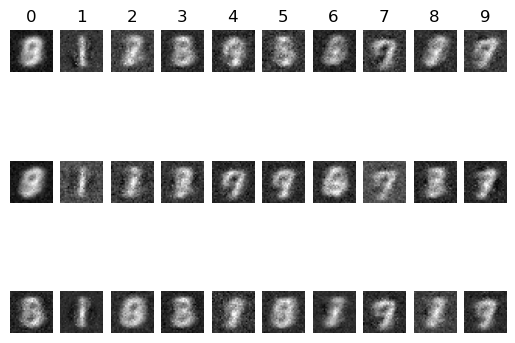

step: 1100, loss: 3340.85
Original Image (step: 1100)


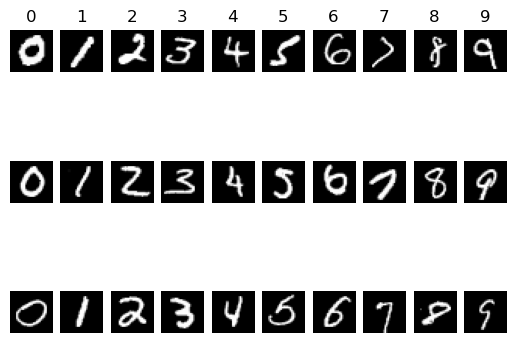


Reconstruction Image (step: 1100)


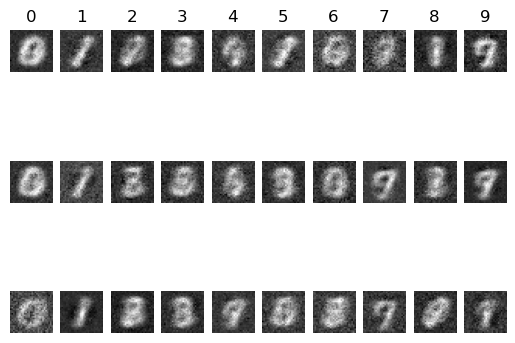

step: 1200, loss: 3197.82
Original Image (step: 1200)


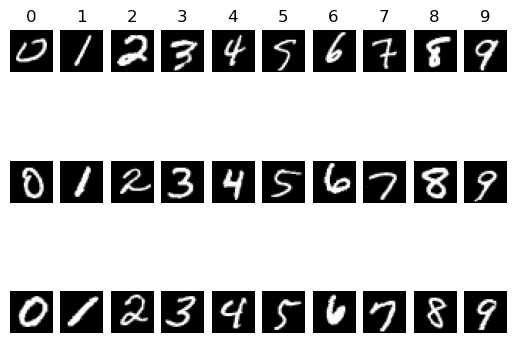


Reconstruction Image (step: 1200)


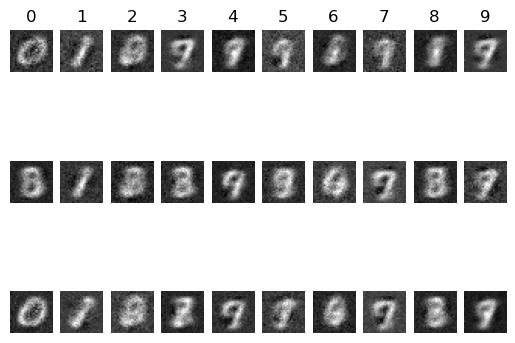

step: 1300, loss: 3054.64
Original Image (step: 1300)


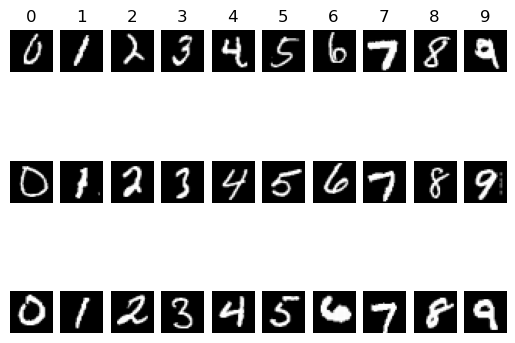


Reconstruction Image (step: 1300)


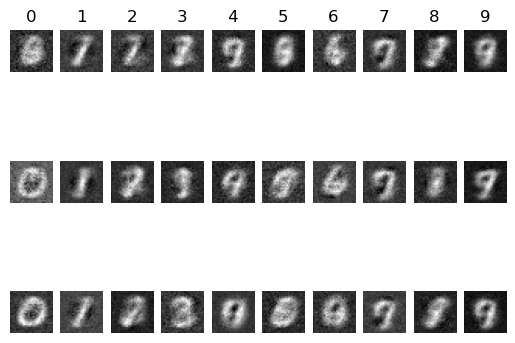

step: 1400, loss: 2847.47
Original Image (step: 1400)


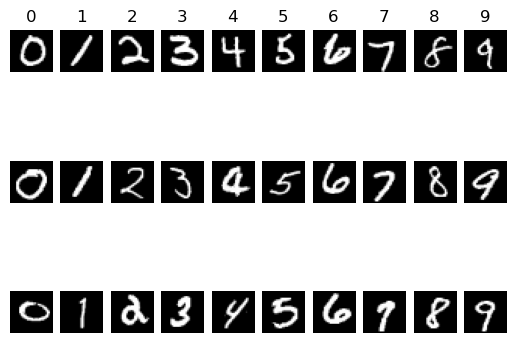


Reconstruction Image (step: 1400)


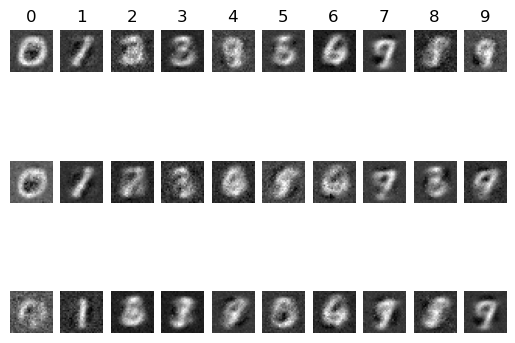

step: 1500, loss: 2762.94
Original Image (step: 1500)


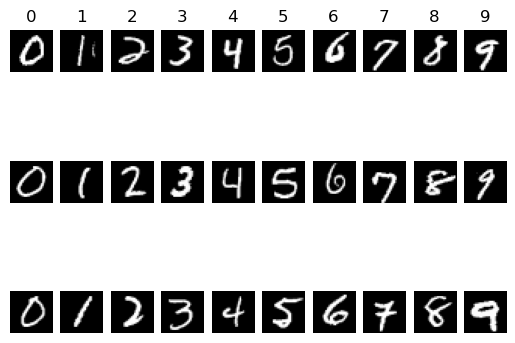


Reconstruction Image (step: 1500)


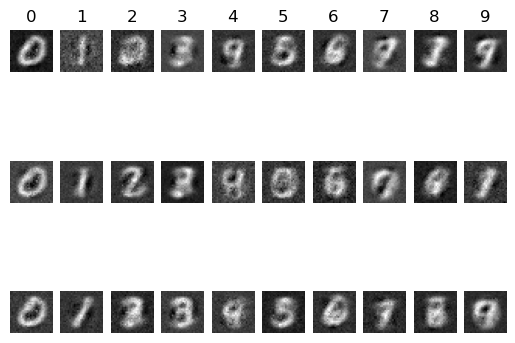

step: 1600, loss: 2706.02
Original Image (step: 1600)


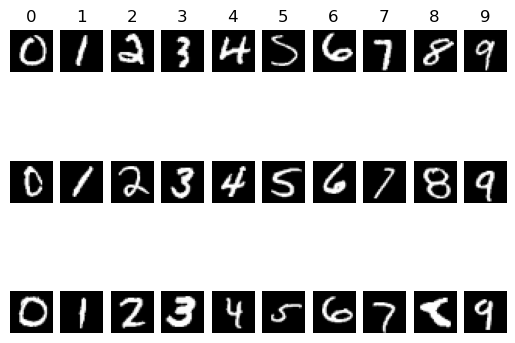


Reconstruction Image (step: 1600)


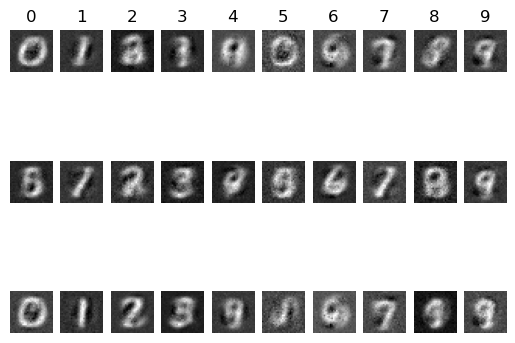

step: 1700, loss: 2610.08
Original Image (step: 1700)


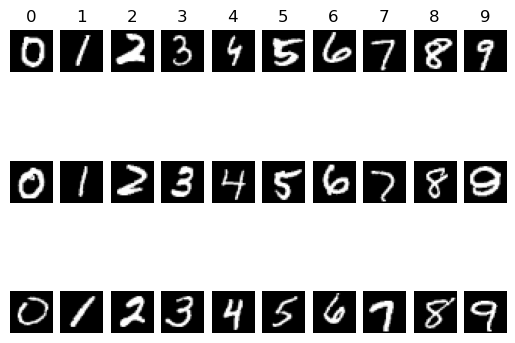


Reconstruction Image (step: 1700)


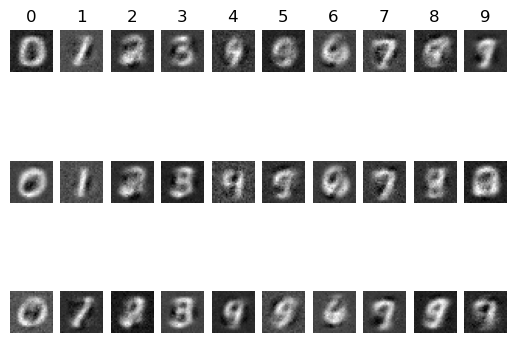

step: 1800, loss: 2515.21
Original Image (step: 1800)


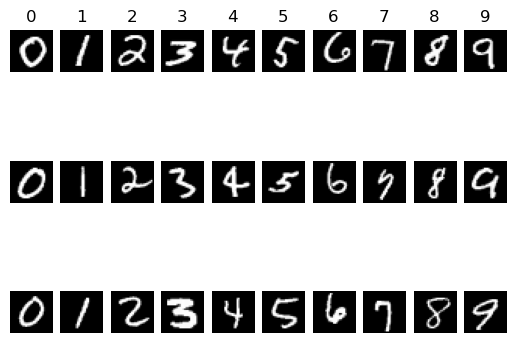


Reconstruction Image (step: 1800)


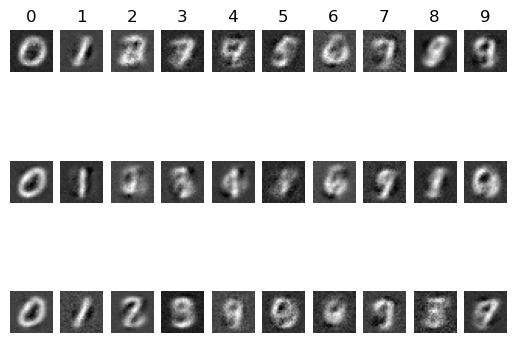

step: 1900, loss: 2469.39
Original Image (step: 1900)


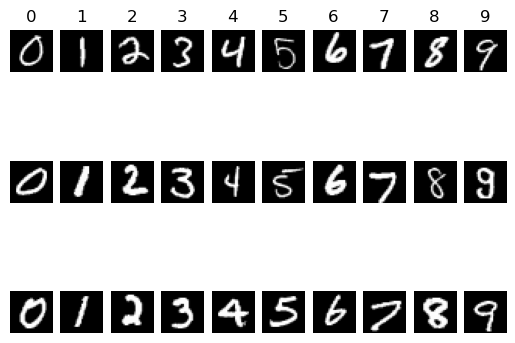


Reconstruction Image (step: 1900)


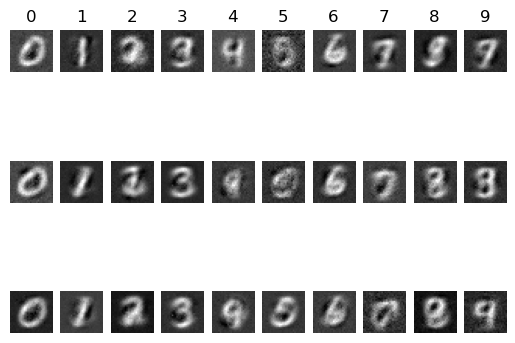

step: 2000, loss: 2441.16
Original Image (step: 2000)


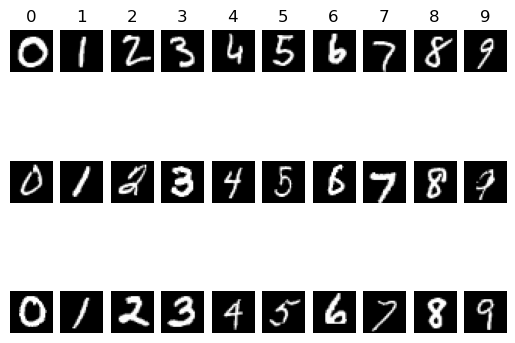


Reconstruction Image (step: 2000)


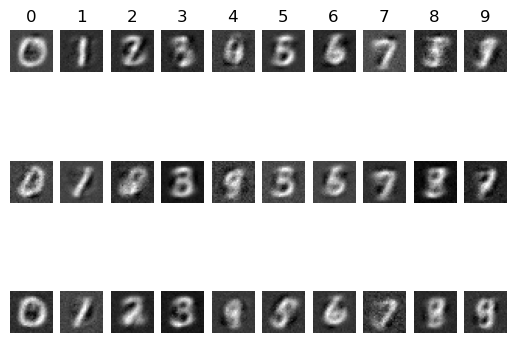

step: 2100, loss: 2466.91
Original Image (step: 2100)


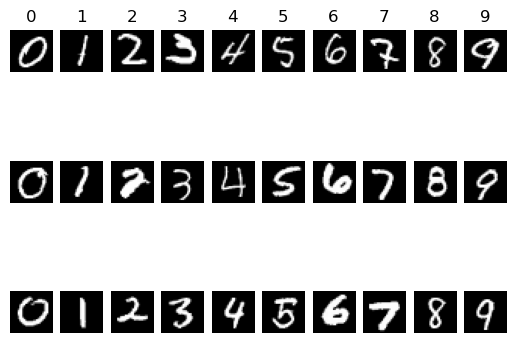


Reconstruction Image (step: 2100)


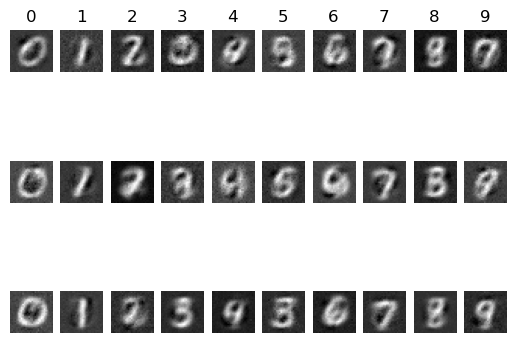

step: 2200, loss: 2360.27
Original Image (step: 2200)


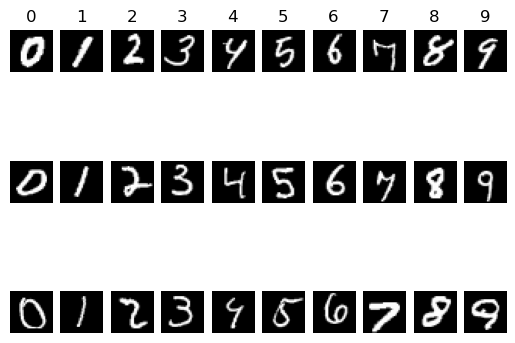


Reconstruction Image (step: 2200)


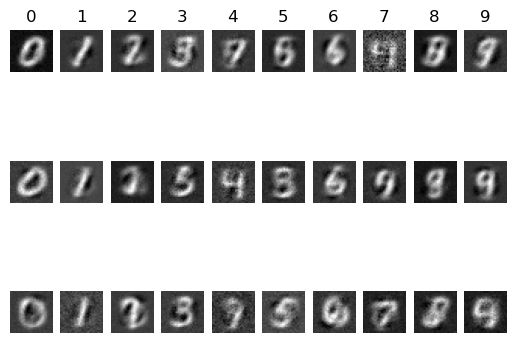

step: 2300, loss: 2308.14
Original Image (step: 2300)


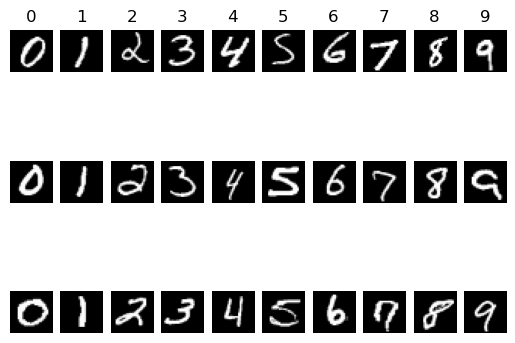


Reconstruction Image (step: 2300)


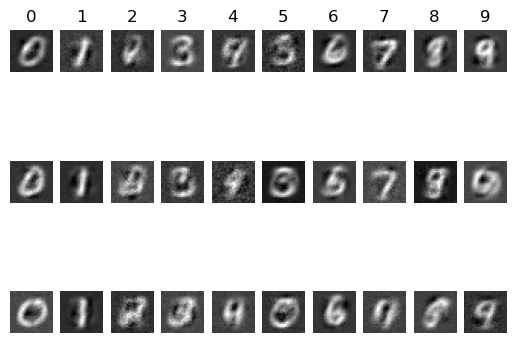

step: 2400, loss: 2258.54
Original Image (step: 2400)


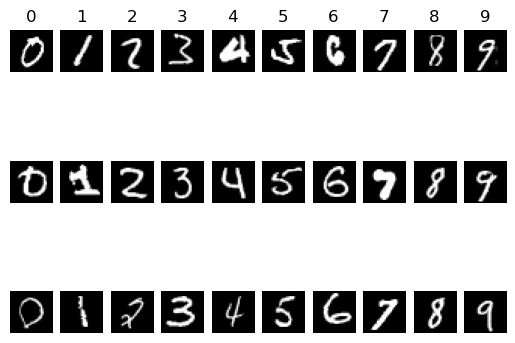


Reconstruction Image (step: 2400)


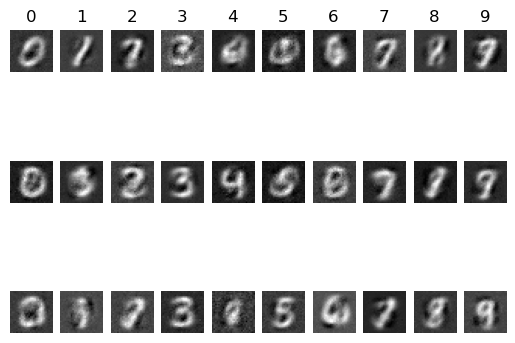

step: 2500, loss: 2263.01
Original Image (step: 2500)


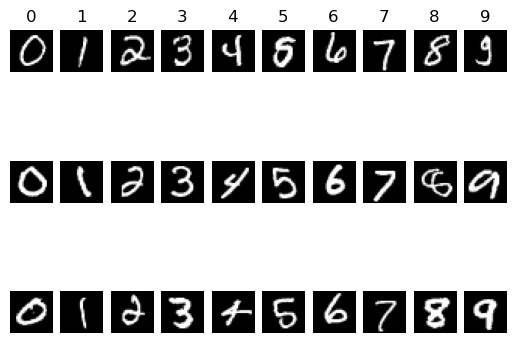


Reconstruction Image (step: 2500)


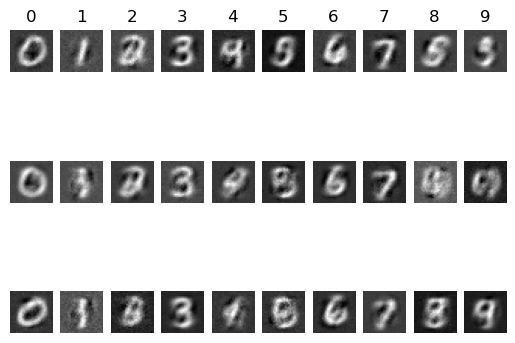

step: 2600, loss: 2209.07
Original Image (step: 2600)


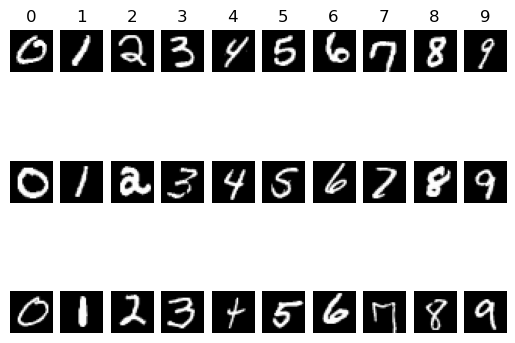


Reconstruction Image (step: 2600)


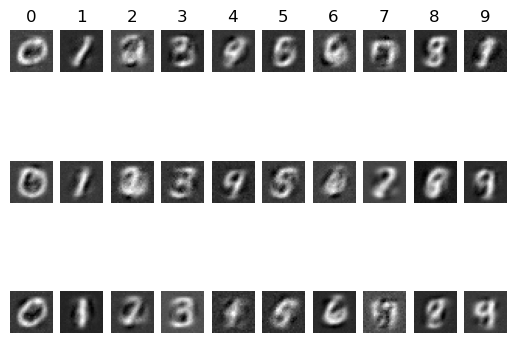

step: 2700, loss: 2108.33
Original Image (step: 2700)


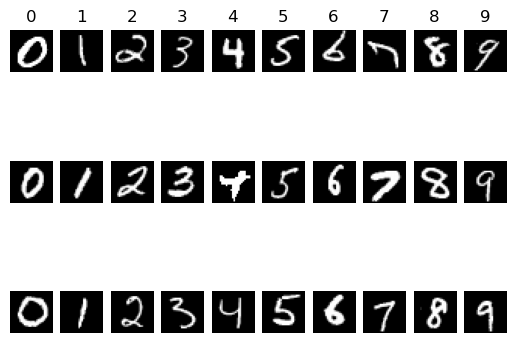


Reconstruction Image (step: 2700)


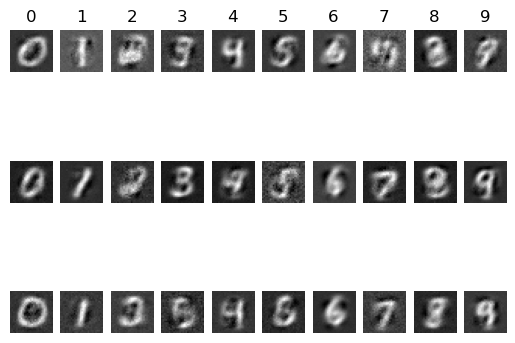

step: 2800, loss: 2158.53
Original Image (step: 2800)


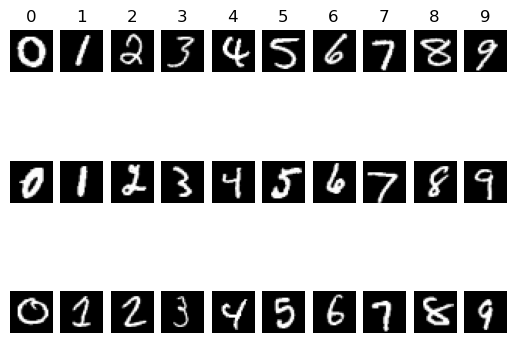


Reconstruction Image (step: 2800)


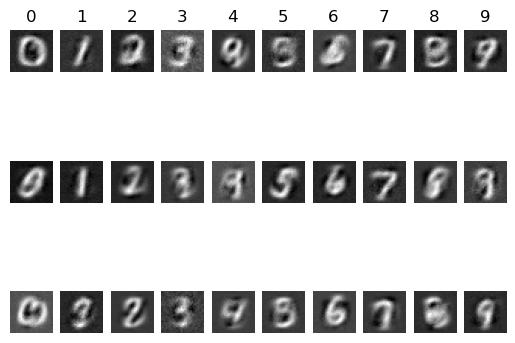

step: 2900, loss: 2102.25
Original Image (step: 2900)


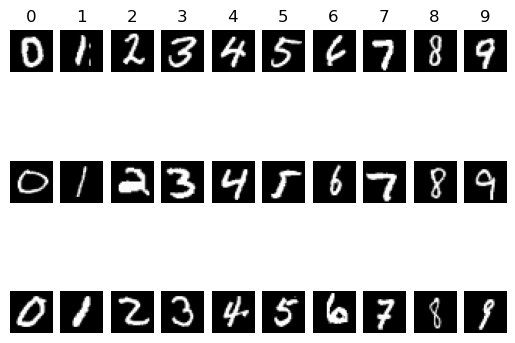


Reconstruction Image (step: 2900)


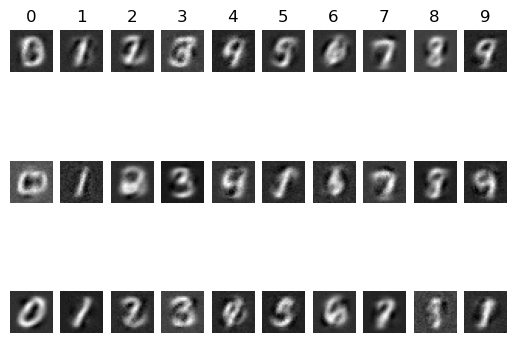

step: 3000, loss: 2098.27
Original Image (step: 3000)


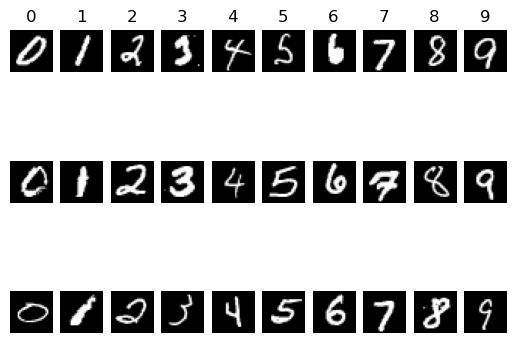


Reconstruction Image (step: 3000)


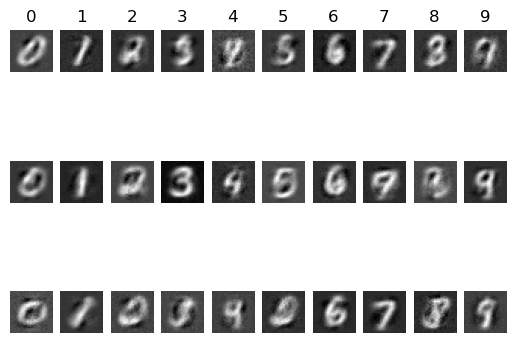

step: 3100, loss: 2065.56
Original Image (step: 3100)


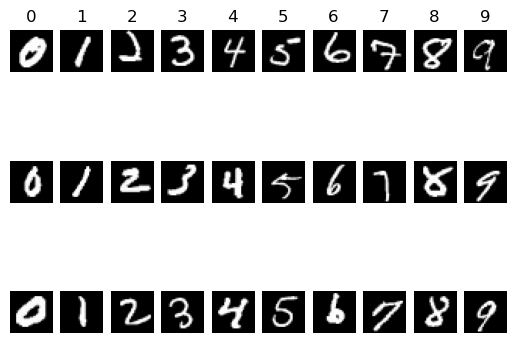


Reconstruction Image (step: 3100)


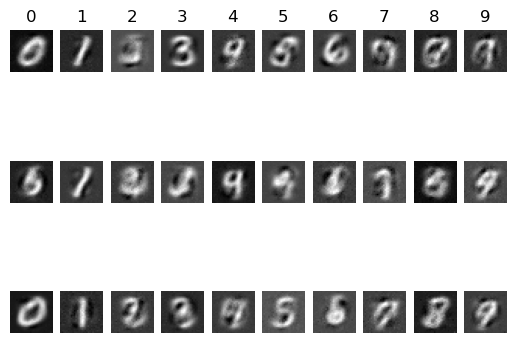

step: 3200, loss: 2037.48
Original Image (step: 3200)


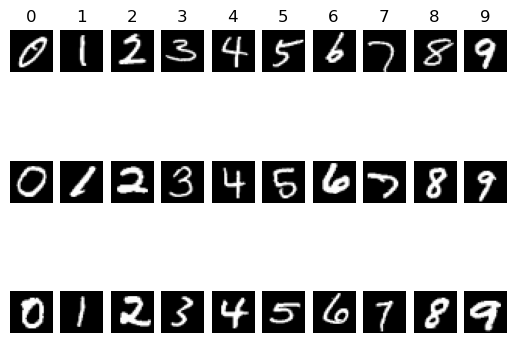


Reconstruction Image (step: 3200)


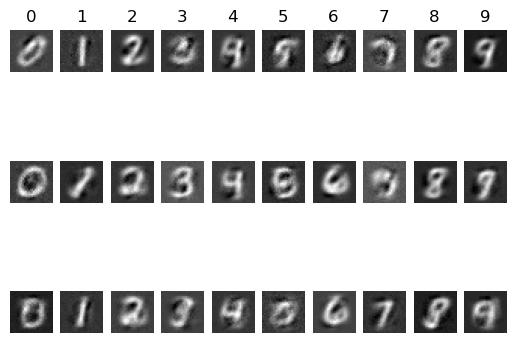

step: 3300, loss: 2011.43
Original Image (step: 3300)


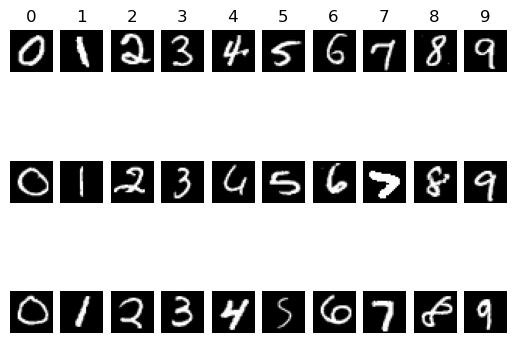


Reconstruction Image (step: 3300)


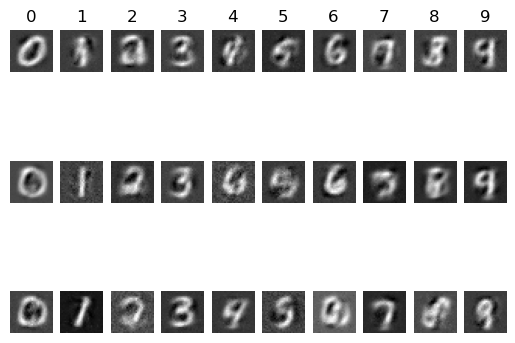

step: 3400, loss: 1925.02
Original Image (step: 3400)


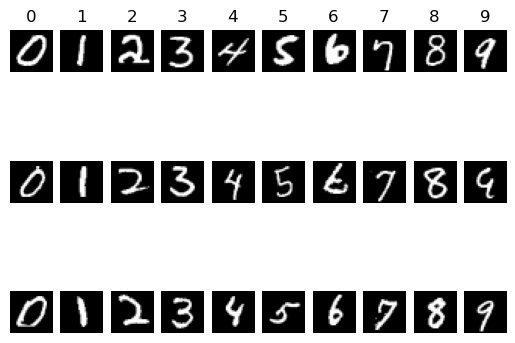


Reconstruction Image (step: 3400)


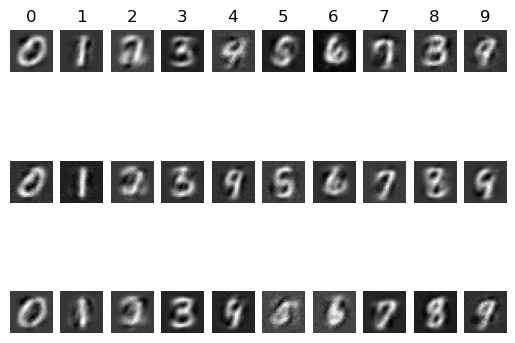

step: 3500, loss: 1898
Original Image (step: 3500)


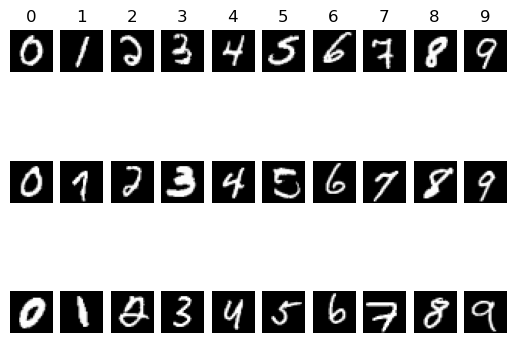


Reconstruction Image (step: 3500)


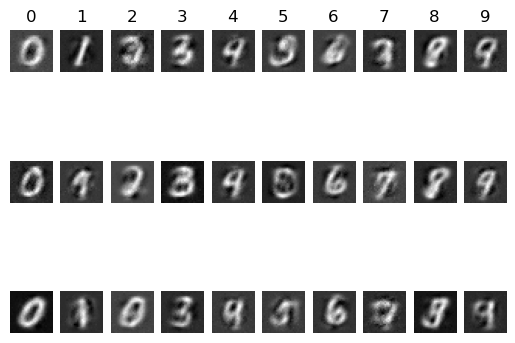

step: 3600, loss: 1914.3
Original Image (step: 3600)


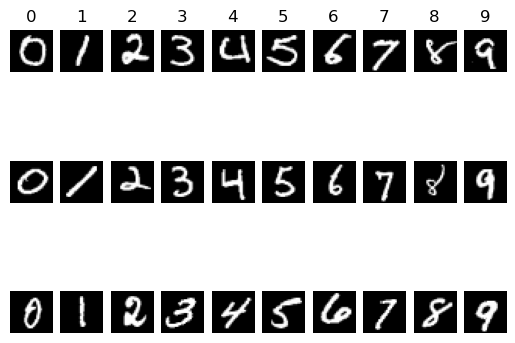


Reconstruction Image (step: 3600)


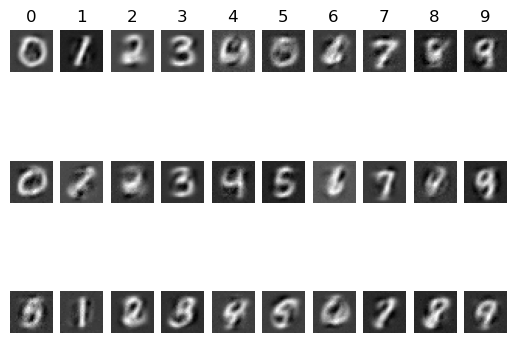

step: 3700, loss: 1891.08
Original Image (step: 3700)


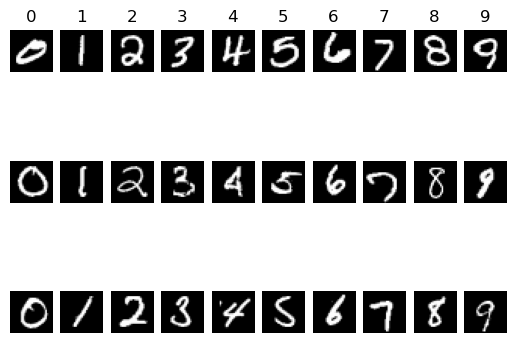


Reconstruction Image (step: 3700)


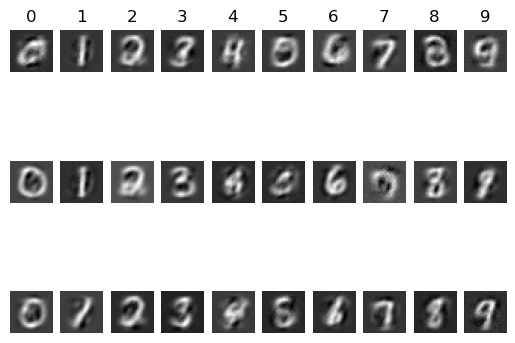

step: 3800, loss: 1859.67
Original Image (step: 3800)


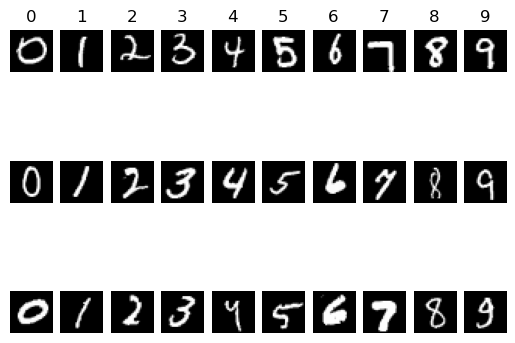


Reconstruction Image (step: 3800)


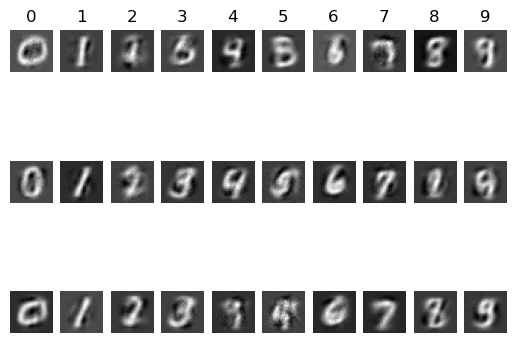

step: 3900, loss: 1853.18
Original Image (step: 3900)


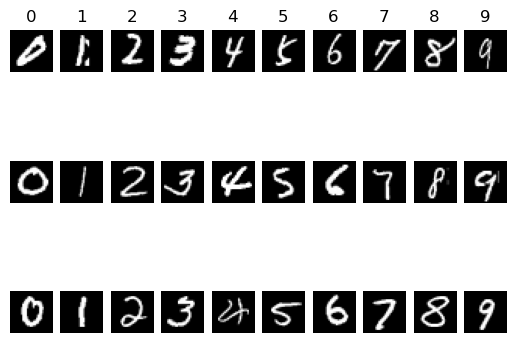


Reconstruction Image (step: 3900)


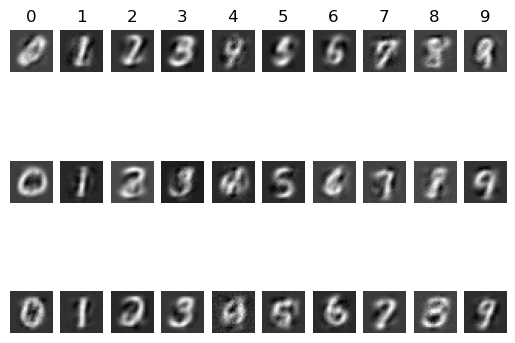

step: 4000, loss: 1864.96
Original Image (step: 4000)


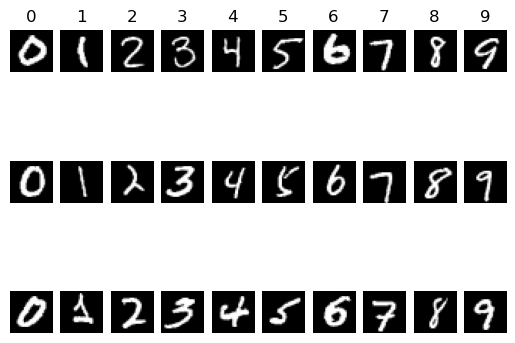


Reconstruction Image (step: 4000)


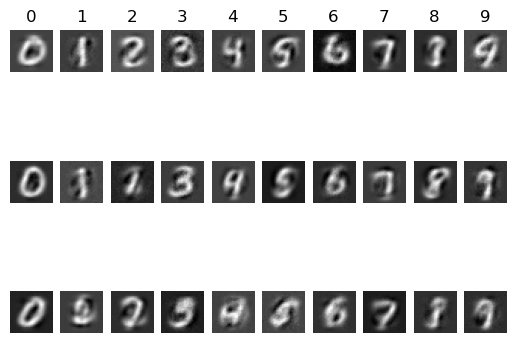

step: 4100, loss: 1822.24
Original Image (step: 4100)


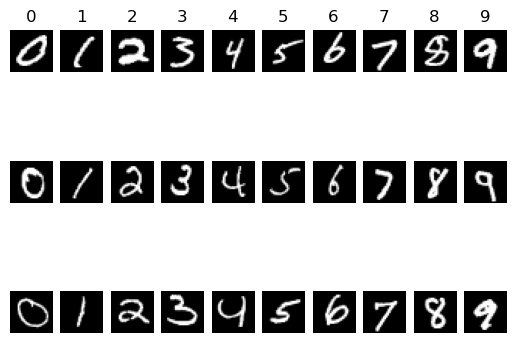


Reconstruction Image (step: 4100)


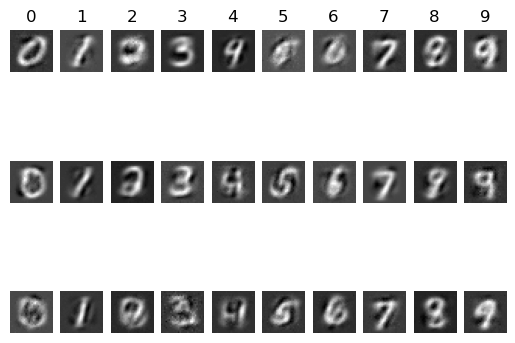

step: 4200, loss: 1806.82
Original Image (step: 4200)


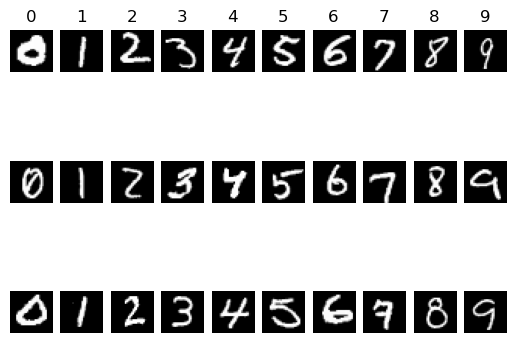


Reconstruction Image (step: 4200)


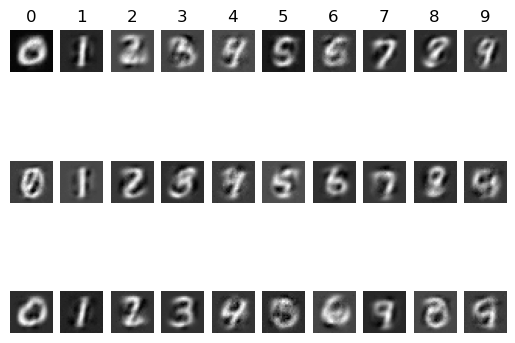

step: 4300, loss: 1742.23
Original Image (step: 4300)


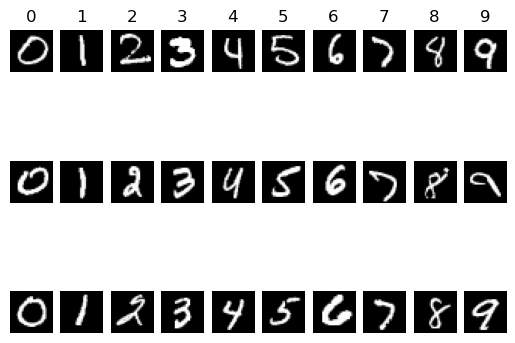


Reconstruction Image (step: 4300)


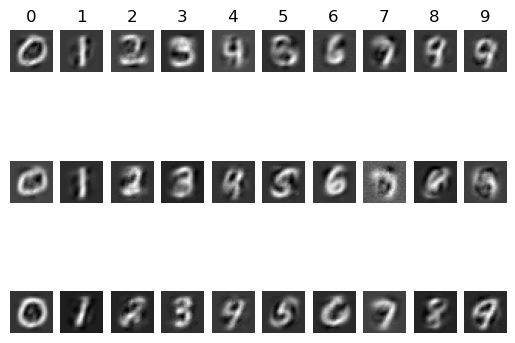

step: 4400, loss: 1741.48
Original Image (step: 4400)


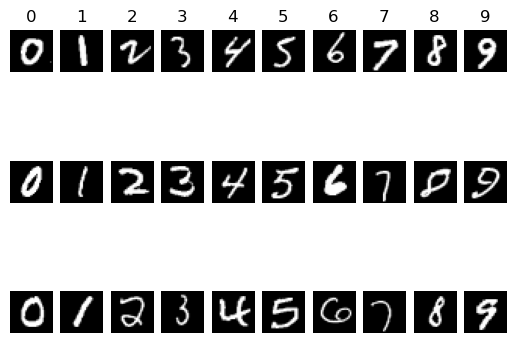


Reconstruction Image (step: 4400)


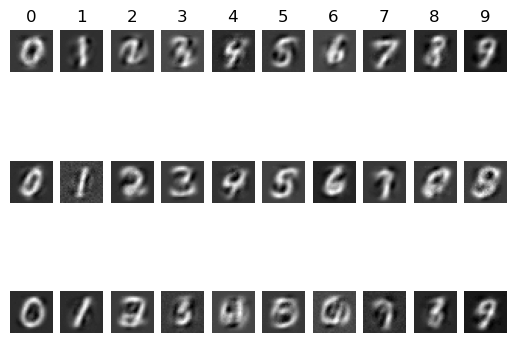

step: 4500, loss: 1804.02
Original Image (step: 4500)


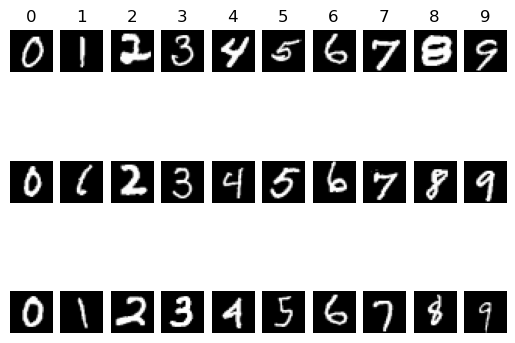


Reconstruction Image (step: 4500)


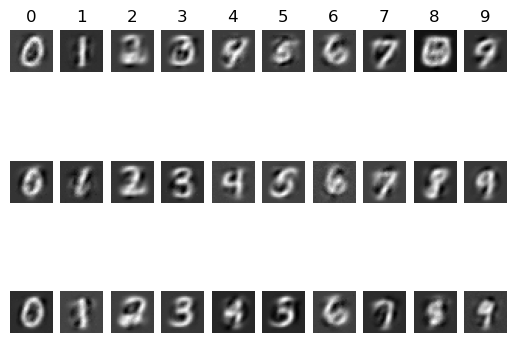

step: 4600, loss: 1739.03
Original Image (step: 4600)


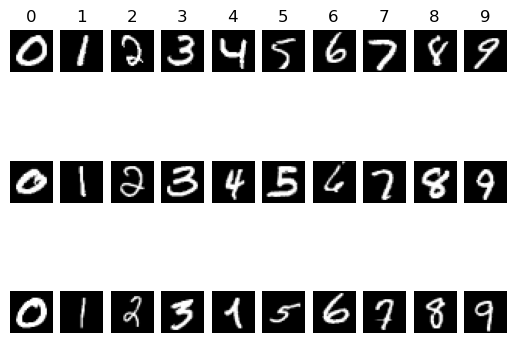


Reconstruction Image (step: 4600)


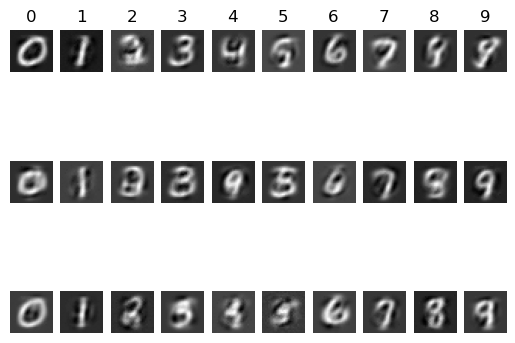

step: 4700, loss: 1745.56
Original Image (step: 4700)


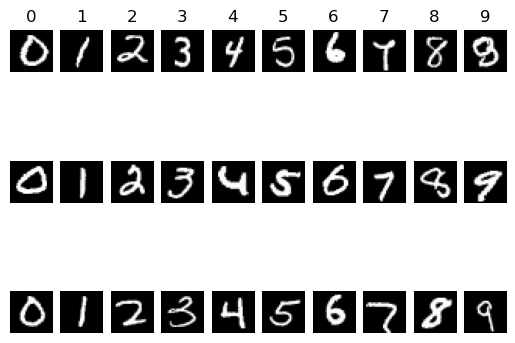


Reconstruction Image (step: 4700)


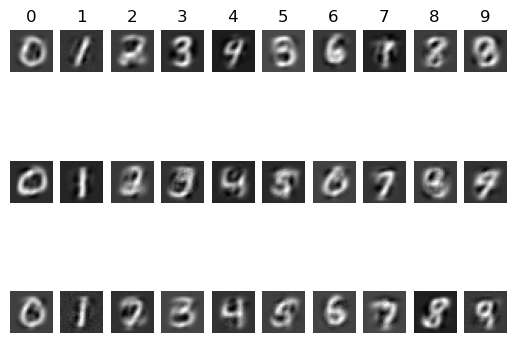

step: 4800, loss: 1715.23
Original Image (step: 4800)


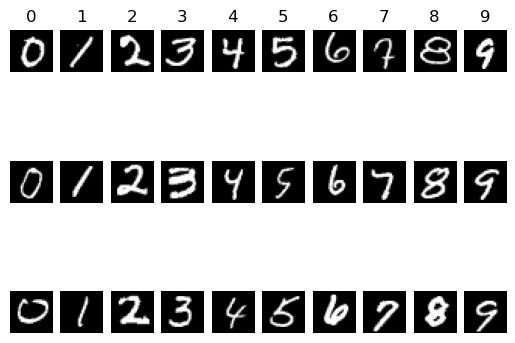


Reconstruction Image (step: 4800)


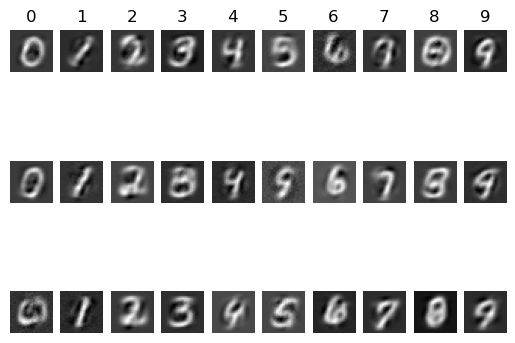

step: 4900, loss: 1704.99
Original Image (step: 4900)


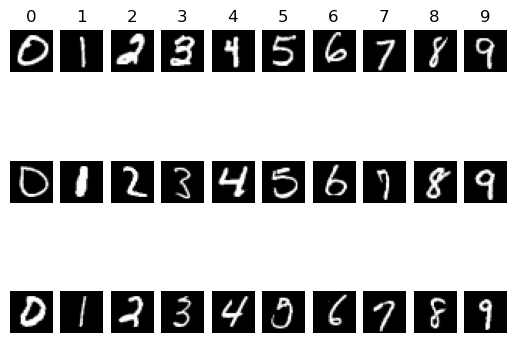


Reconstruction Image (step: 4900)


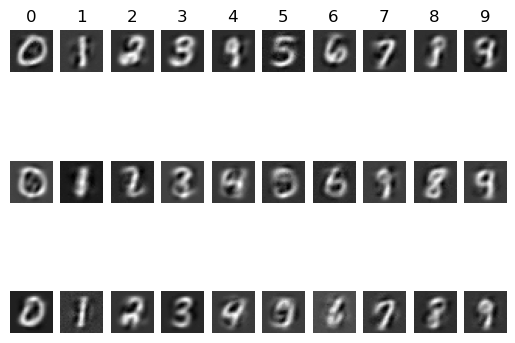

In [48]:
#이 블록에선 학습이 실제로 진행됨.
x_train = x_train.reshape(-1, 28 * 28) 
#28*28 이미지를 1차원 벡터(-1,784)로 펴주는 작업. -1은 자동으로 맞춰달란 뜻으로, 60000이 되는 것.
for i in range(num_of_iter):
    #iter 수 설정한 만큼 학습 반복. 5000번.
    idx = np.random.randint(0, x_train.shape[0], size=batch_size)
    #랜덤으로 샘플 1000개의 인덱스를 뽑음. 0부터 60000까지 1000개를 뽑게 됨.
    batch_image_flat = x_train[idx]
    #인덱스를 데이터셋에 넣어서 샘플 데이터셋을 만듬.
    _,loss, reconstruction = sess.run([ae.optimizer, ae.loss,
        ae.reconstruction], feed_dict={ae.x_input: batch_image_flat})
    #핵심코드. 최적화 과정, 손실, 재구축 연산을 불러와서 실행. 이후 최적화 결과는 버리고, 손실값, 재구성된 이미지를 각각 저장함.
    if i%100==0:
        #100번 학습시마다 중간보고
        print("step: %d, loss: %g"%(i, loss))
        classes=np.argmax(y_train[idx], axis=1)
        #원 핫 인코딩에서 숫자로 바꾸어 줌.
        print("Original Image (step: %d)"%(i))
        plot_image(x_train[idx], classes)
        #원본을 출력함.
        print("")
        print("Reconstruction Image (step: %d)"%(i))
        reconstruction = reconstruction.reshape(-1, 28, 28)
        #784개로 나왔던 reconstruction을 다시 28*28 이미지로 변형함.
        plot_image(reconstruction, classes)
        #이미지 출력. 끝~!!!